In [1]:
import numpy as np
from nm_lib import nm_lib as nm
import threading

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from scipy.optimize import curve_fit

import time

# Space-time partial differential equation: Study of the diffusive equation (implicit methods)

Let's consider now the viscous term in Burger's equation: 

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}, \tag{1}$$

## 1- Apply an explicit method. 

What would be the CFL condition for a viscous term where $\nu$ is either a constant or an array that depends on $x$. We would like to solve equation (1) numerically for $x  [x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, periodic boundary conditions and with the initial condition:

$$u(x,t=t_0) = A\exp(-(x-x_0)^2/W^2)   \tag{2}$$

with $A=0.3$, $W=0.1$, and $x_0=0$. __Suggestion__: Apply the first derivative upwind and the second downwind. Apply Von Newman analysis. Is it stable? What is the time-step dependence with $\Delta x$? 

How many steps are needed to reach a $t=1.8$ for $nump=128$? And $256$? 

In [2]:
def u(x, A, W):
    x0 = 0
    return A * np.exp(-(-x-x0)**2/W**2)

x0 = -2.6
xf = 2.6

def get_xx(x0, xf, nump):
    return np.arange(nump)/(nump-1.0) * (xf-x0) + x0

A = 0.3
W = 0.1

The viscous term using Forward-Euler in time and First upwind then downwind in space:

\begin{align}
\frac{u_j^{n+1}-u_j^n}{\Delta t} &= \nu \frac{(u_{j+1}^n - 2u_j^n + u_{j-1}^n)}{\Delta x^2}.\\
\end{align}

Now Von Neumann analysis of the viscous term, first assume peculiar solution on the form

$$
u_j^n = \xi^n e^{ikj\Delta x}.
$$

Inserting this in the equation above gives
\begin{align}
e^{ikj\Delta x}\frac{\xi^{n+1}-\xi^{n}}{\Delta t} &= \nu \xi^n e^{ikj\Delta x} \frac{e^{ik\Delta x}-2+e^{-ik\Delta x}}{\Delta x^2}\\
\frac{\xi^{n+1}-\xi^{n}}{\xi^n} &=   \frac{\nu\Delta t}{\Delta x^2}\left(e^{ik\Delta x}-2+e^{-ik\Delta x}\right)\\
\xi &=\frac{\nu\Delta t}{\Delta x^2}\left(\cos{(k\Delta x)}+i\sin{(k\Delta x)} -2+\cos{(k\Delta x)-i\sin{(k\Delta x)}} \right) +1\\
\xi &=\frac{2\nu\Delta t}{\Delta x^2}\left(\cos{(k\Delta x)} -1 \right) +1\\
\xi &=-\frac{4\nu\Delta t}{\Delta x^2}\sin^2{\left(\frac{k\Delta x}{2}\right)} + 1
\end{align}

We require that $|\xi^n|^2\leq 1$ for all $k$. This gives

\begin{align}
\left|-\frac{4\nu\Delta t}{\Delta x^2}\sin^2{\left(\frac{k\Delta x}{2}\right)} + 1 \right|^2 &\leq 1\\
\frac{16\nu^2\Delta t^2}{\Delta x^4}\sin^4{\left(\frac{k\Delta x}{2}\right)} - \frac{4\nu\Delta t}{\Delta x^2}\sin^2{\left(\frac{k\Delta x}{2}\right)} + 1 &\leq 1
\end{align}

This needs to hold for all $k$, so we look at the max of the sine function

$$
\frac{16\nu^2\Delta t^2}{\Delta x^4} - \frac{4\nu\Delta t}{\Delta x^2} + 1 \leq 1
$$

\begin{align}
\frac{16\nu^2\Delta t^2}{\Delta x^4} &\leq \frac{4\nu\Delta t}{\Delta x^2}\\
\frac{4\nu \Delta t}{\Delta x^2} &\leq 1
\end{align}

$$
\Delta t \leq \frac{\Delta x^2}{4\nu}
$$

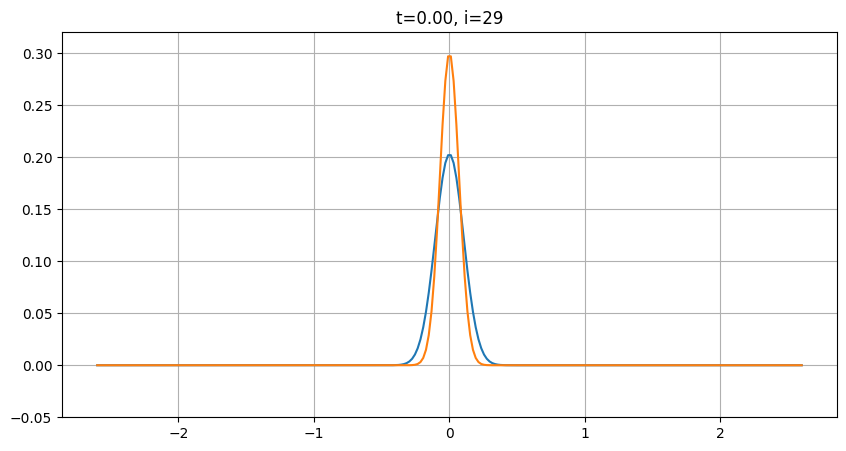

In [21]:
xx = get_xx(x0, xf, nump=256)
hh = u(xx, A, W)
nt = 30
dt = 1.1
a = 1

tt_diff, unnt_diff = nm.evolv_diff_burgers(xx, hh,nt, a, cfl_cut = 0.98)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
def init(): 
    axes.plot(xx,unnt_diff[0,:])
    axes.set_ylim(-0.05, 0.32)
    axes.grid(True)

def animate(i):
    axes.clear()
    axes.plot(xx,unnt_diff[i,:])
    axes.set_ylim(-0.05, 0.32)
    axes.set_title('t={:.2f}, i={:g}'.format(tt_diff[i],i))
    axes.grid(True)

anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

In the above figure we see the explicit method for $\nu=-1$. This looks very diffusive and $dt$ is very small so I will not run it untill $t=1.8$. Possibly something wrong in the solver evolv_diff_burgers?

<span style="color:green">JMS</span>.

<span style="color:blue">You almost did it correct. The expression (1) is supposed to be diffusive term for </span>.

    $$a>0$$. 
    
<span style="color:blue">For </span>.

    $$a<0$$. 

<span style="color:blue">it is physically unstable, so, unless the numerical diffusive is stronger than the coefficient 

    $$a<0$$, 
    
<span style="color:blue"> the evolution will be diffusive, otherwise unstable, but this time, not numerically but physically.</span>.

<span style="color:red">To fix the explicit scheme you need to remove the negative sign `step_diff_burgers` function.</span>.


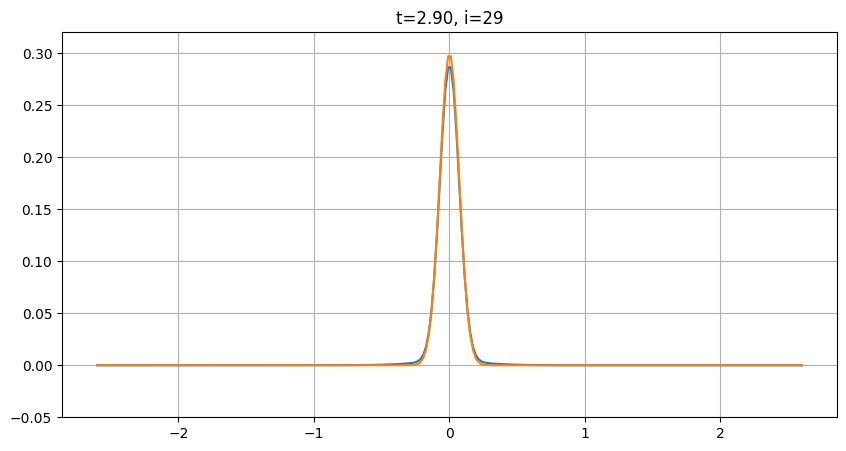

In [5]:
t, unnt, errt, countt = nm.Newton_Raphson(xx, hh, a, dt, nt, toll= 1e-5, ncount=5, bnd_type='wrap', bnd_limits=[1,1])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
def init(): 
    axes.plot(xx,unnt[:,0])
    axes.set_ylim(-0.05, 0.32)
    axes.grid(True)

def animate(i):
    axes.clear()
    axes.plot(xx,unnt[:,i])
    axes.set_ylim(-0.05, 0.32)
    axes.set_title('t={:.2f}, i={:g}'.format(t[i],i))
    axes.grid(True)

anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

And here we see the implicit newton rapson method for the same nt and xx. Much less diffusive.

<span style="color:green">JMS</span>.

<span style="color:red"> the NR method should follow the explicit solution. It should be faster though. The problem is that the iterations didn't converge. Try to increase ncount. Note that you can incrase dt to greater values to have larger time-steps with the NR method (but unfortunately this can not be extremely large otherwise the error starts to increase). </span>.

## Choose one of the following options: 

## 2- Implicit methods.

In the [wiki](https://github.com/AST-Course/AST5110/wiki/Implicit-methods), we describe some implicit or semi-explicit methods that allow relaxing the CFL constraint on diffusive terms. Consider Newton-Rapson method and repeat the previous numerical experiment. For this, you will need to implement the following   


$F_j = u^{n+1}_j - u^n_j - \nu \, (u^{n+1}_{j+1} - 2u^{n+1}_{j}+u^{n+1}_{j-1})\frac{\Delta t}{\Delta x^2}$

in `NR_f` and `step_diff_burgers` functions in `nm_lib`. 

And the Jacobian can be easily built. 

$J(j,k) = F_j'(u^{n+1}_k)$

fill in the `jacobian` function in `nm_lib`. Note that this matrix is linear with $u$. 

Test the model with [wiki](https://github.com/AST-Course/AST5110/wiki/Self-similar-solution-for-parabolic-eq) self-similar solutions. How long it takes each time step compared to the Lax-method? Use `time.time` library. Do it for nump=256, nt=30 and dt = 0.1.

In [16]:


xx = get_xx(x0, xf, nump=256)
hh = u(xx, A, W)
nt = 30
dt = 0.1
a = -1

n_times = 10

lax_times = np.zeros(n_times)
for i in range(n_times):
    start = time.time()
    nm.evolv_Lax_adv_burgers(xx, hh,nt, a, cfl_cut = 0.98)
    end = time.time()
    lax_times[i] = end-start

nr_times = np.zeros(n_times)
for i in range(n_times):
    start = time.time()
    nm.Newton_Raphson(xx, hh, a, dt, nt, toll= 1e-5, ncount=2, bnd_type='wrap', bnd_limits=[1,1])
    end = time.time()
    nr_times[i] = end - start
    
mean_lax = np.mean(lax_times)
std_lax = np.std(lax_times)

mean_nr = np.mean(nr_times)
std_nr = np.std(nr_times)

In [17]:
print("Time lax: {:.1e}+-{:.1e}".format(mean_lax, std_lax))
print("Time NR: {:.1e}+-{:.1e}".format(mean_nr, std_nr))

Time lax: 6.9e-03+-2.3e-03
Time NR: 1.1e-01+-2.5e-02


The Newton-Rapson method is about two orders of magnitude slower.

<span style="color:green">JMS</span>.

<span style="color:red"> You should compare with evolv_diff_burgers instead of evolv_Lax_adv_burgers.  </span>.

In order to test the simulation, use `curve_fit` from `scipy.optimize`. 

__hint__ consider to use a good initial guess (`p0`) in and `bnd_limits` to facilitate the fitting wiht `curve_fit`. What happens to the solution when increasing dt? How much can be improved in limiting the tolerance?

The self similar solution says that the height of the gaussian should go like $t^{-1/2}$ and the width should go like $t^{1/2}$.

In [18]:
t, unnt, errt, countt = nm.Newton_Raphson(xx, hh, a, dt, nt, toll= 1e-5, ncount=2, bnd_type='wrap', bnd_limits=[1,1])

NameError: name 'fwhms' is not defined

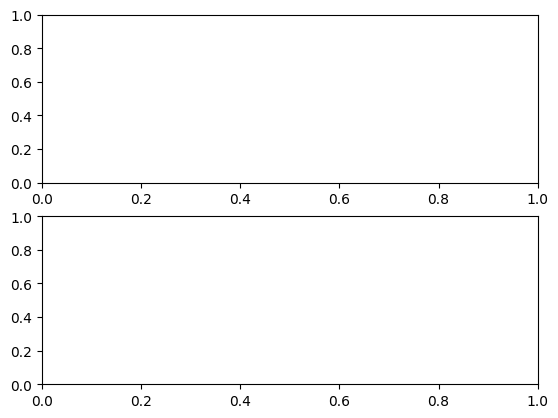

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].loglog(t, fwhms)
ax[1].loglog(t, peaks)

<span style="color:green">JMS</span>.

<span style="color:red"> Here I'm missing some previous calcualtions  </span>.

This plot is not linear so it does not seem that the peak and the fwhm goes as a power law.

In [10]:
def gaussian(x, mu, sigma, norm):
    p = np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    p = p/norm
    return p

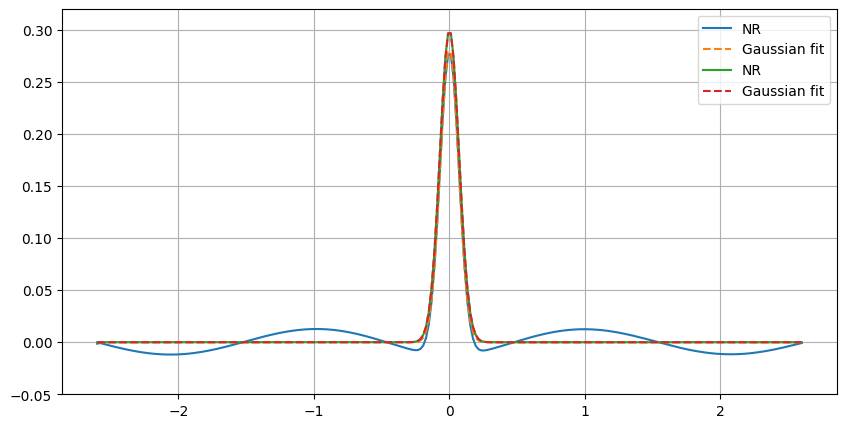

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
def init(): 
    axes.set_ylim(-0.05, 0.32)
    axes.plot(xx,unnt[:,0], label="NR")
    popt, pcov = curve_fit(gaussian, xx, unnt[:,0], p0=[0, 0.3, 0.3])
    axes.plot(xx, gaussian(xx, *popt), label="Gaussian fit", linestyle="--")
    axes.grid(True)
    axes.legend()

def animate(i):
    axes.clear()
    axes.plot(xx,unnt[:,i], label="NR")
    axes.set_ylim(-0.05, 0.32)
    popt, pcov = curve_fit(gaussian, xx, unnt[:,i], p0=[0, 0.3, 0.3])
    axes.plot(xx, gaussian(xx, *popt), label="Gaussian fit", linestyle="--")
    axes.grid(True)
    axes.legend()
    
anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

<span style="color:green">JMS</span>.

<span style="color:red"> Good job with the fitting, but as mentioned above. The problem is that the iterations didn't converge. Try to increase ncount.  </span>.

----------------------------------------------

Let's consider a non-linear function where $\nu$ depends on $u$. To keep it simple, solve the following: 

$\frac{\partial u}{\partial t} = u \frac{\partial^2 u}{\partial x^2}$

where $\nu_0$ is a constant and the same initial conditions as the previous exercise (fill in `Newton_Raphson_u`, `jacobian_u` and `NR_f_u`. Consider an error limit of $10^{-4}$ and compare the previous exercise (with the same error limit). How many iterations needs now the method to converge to the right solution? Why? Increase `ncount` to 1000. 

In [12]:
t, unnt, errt, countt = nm.Newton_Raphson_u(xx, hh, dt, nt, toll= 1e-4, ncount=1000, bnd_type='wrap', bnd_limits=[1,1])

In [13]:
print(countt)

[0. 8. 8. 8. 8. 8. 8. 8. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.
 7. 7. 7. 7. 7. 7.]


Needs 7-8 to reach the error limit.

In [14]:
t, unnt, errt, countt = nm.Newton_Raphson_u(xx, hh, dt, nt, toll= 1e-6, ncount=1000, bnd_type='wrap', bnd_limits=[1,1])

In [15]:
print(countt)

[  0. 121. 120. 119. 118. 117. 116. 115. 114. 114. 113. 112. 111. 110.
 110. 109. 108. 107. 106. 106. 105. 104. 103. 103. 102. 101. 100. 100.
  99.  98.]


<span style="color:green">JMS</span>.

<span style="color:red"> Good job! how does this compare with the case Newton_Raphson. One is linear and the other is not linear, so it needs many more iterations to find a solution </span>.

And we see that it is much higher with lower tolerance.

## 3- Semi-explicit methods. 

__a)__ Super-time-stepping (STS) schemes work for parabolic terms. STS is an API method that performs a subset of "unstable" intermediate steps, but the sum of all the steps is stable. Visualize how `taui_sts` varies with $nu$ and $niter$. Compare the solution with the analytical one for the final and intermediate STS steps. For the full STS steps, how improves the solution with $nu$? and $niter$? Is there a relation between the error and these two parameters, $nu$, and $niter$? For which $niter$ and $nu$ the method provides larger steps than an ordinary explicit. For this exercise, fill in `evol_sts`, and `taui_sts`. 